In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed

from IntTool.utils import symmetrize, symmetrize_2d, critical_density

### Параметры эксперимента

In [2]:
wavelength = 0.400 # mkm
mkm_per_pixel = 1

### Пути к фазе, которую необходимо симметризовать, и директории, куда будет записан результат

In [3]:
ABEL_PATH = './abel_folder'
if not os.path.exists(ABEL_PATH):
    os.mkdir(ABEL_PATH)
    
path = './input.dat'
phase = np.loadtxt(open(path), skiprows=1) * (-1)

# Симметризация фазы

In [4]:
r = np.arange(phase.shape[0])
z = np.arange(phase.shape[1])

symmetrical_phase = None

@interact(img=fixed(phase),
          r0 = IntSlider(min=r[0], max=r[-1], step=10, continuous_update=False, value=r.size//2),
          z0 = IntSlider(min=z[0], max=z[-1], step=10, continuous_update=False, value=z.size//2),
          color=fixed('black')
         )
def search_mask(img, r0, z0, color):
    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.plot([z0, z0], [0, img.shape[0] - 1], color)
    plt.plot([0, img.shape[1] - 1], [r0, r0], color)
    
    plt.subplot(132)
    plt.plot(phase[:, z0])
    section_symm = symmetrize(phase[:, z0], r0)
    section_symm_x = r0 - section_symm.size // 2 + np.arange(0, section_symm.size)
    plt.plot(section_symm_x, section_symm)
    plt.plot([r0, r0], [phase[:,z0].min(), phase[:,z0].max()], color)
    
    global symmetrical_phase
    symmetrical_phase = symmetrize_2d(phase, r0)
    
    plt.subplot(133)
    plt.imshow(symmetrical_phase, cmap='jet')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=443, continuous_update=False, description='r0', max=886, step=10), IntSl…

# запись результатов в файлы

In [5]:
for j in range(symmetrical_phase.shape[1]):
    with open(os.path.join(ABEL_PATH, str(j) + '.dat'), 'wb') as out_file:
        head = 'AB ' + str(symmetrical_phase.shape[0]) + ' %.6g\n'
        np.savetxt(out_file, symmetrical_phase[:, j], header=head, newline=' ', comments='')

# Дальше код следует выполнять после преобразования Абеля в IDEA
# чтение результатов и объединение в одно изображение

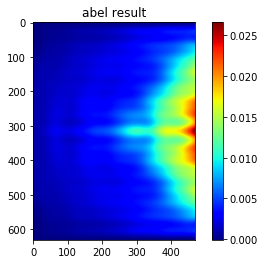

In [119]:
num_of_files = int(len(os.listdir(ABEL_PATH)) / 2) # число столбцов матрицы
size_of_file = 0 # число строк матрицы
input_file = open(os.path.join(ABEL_PATH,'Abel0.dat'), 'rt')

# открываем файл, узнаем размер число строк матрицы, закрываем файл
size_of_file = int(input_file.readline().split()[1])
input_file.close()

abel_result = np.zeros((size_of_file, num_of_files))

# заполняем списки данными
for j in range(num_of_files):
    input_file = open(os.path.join(ABEL_PATH,'Abel{}.dat'.format(j)), 'rt')
    input_file.readline()
    for k in range(size_of_file):
        abel_result[k][j] = float(input_file.readline().strip())
    input_file.close()
    
plt.imshow(abel_result, cmap='jet')
plt.title('abel result')
plt.colorbar()
plt.show()

# пересчет в электронную концентрацию

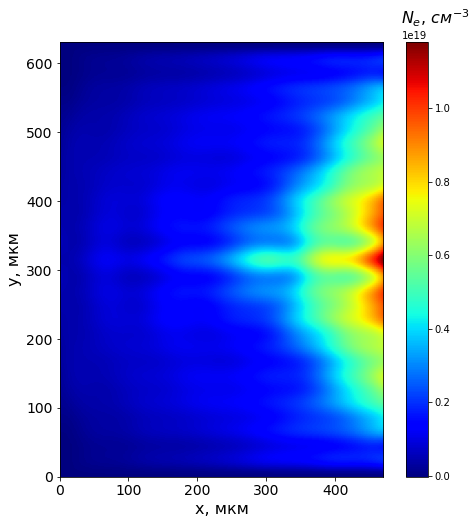

In [120]:
ne = (1 - (1 - abel_result * wavelength / (2 * np.pi * mkm_per_pixel))**2) * criticalDensity(wavelength)

plt.figure(figsize=(8,8))
plt.imshow(
    ne, 
    cmap='jet', 
    extent=(0,ne.shape[1]*mkm_per_pixel,0,ne.shape[0]*mkm_per_pixel)
)
cbar = plt.colorbar()
cbar.set_label(r'$N_e$' + r', ' + r'$см^{-3}$', rotation=0, labelpad=-15, y=1.08, fontsize=16)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./ne.png', format='png', dpi=100)
plt.show()